In [1]:
!pip install -U langgraph langchain-groq langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 10.4 MB/s eta 0:00:00


In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


In [3]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [4]:
from typing import Annotated
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [6]:
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [7]:
tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatGroq(model="qwen-2.5-32b")
llm_with_tools = llm.bind_tools(tools)

In [8]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

In [9]:
graph_builder.add_node("chatbot", chatbot)

In [10]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [11]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [12]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [13]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

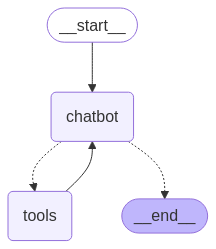

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_awwv)
 Call ID: call_awwv
  Args:
    query: I need some expert guidance for building an AI agent.


In [16]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_awwv)
 Call ID: call_awwv
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts are here to assist you! They recommend checking out LangGraph for building your AI agent. LangGraph is noted as being much more reliable and extensible compared to simpler autonomous agents.


In [17]:
user_input = "Who has won the last ipl match?"
config = {"configurable": {"thread_id": "2"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Who has won the last ipl match?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_35r7)
 Call ID: call_35r7
  Args:
    query: last ipl match winner
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Yesterday IPL Match Result 2025 - Sportskeeda", "url": "https://www.sportskeeda.com/cricket/yesterday-ipl-match-result", "content": "Who won yesterday's IPL match?\nSunrisers Hyderabad (SRH) - 113/10 (18.3 overs)\nKolkata Knight Riders (KKR) - 114/2 (10.3 overs) [...] Yesterday's IPL match most sixes\nKKR's Venkatesh Iyer smashed the most sixes in the match. The left-handed batter hit three sixes during his unbeaten, match-winning knock of 52.\nRead Less  \nFAQs on IPL\nQ. Who won the IPL 2024? - +\nA. Kolkata Knight Riders won the IPL 2024, beating Sunriser